In [1]:
from lbmpy.session import *

# Tutorial 03: Defining LB methods in *lbmpy*


## A) General Form

The lattice Boltzmann equation in its most general form is:

$$f_q(\mathbf{x} + \mathbf{c}_q \delta t, t+\delta t) = K\left( f_q(\mathbf{x}, t) \right)$$

with a discrete velocity set $\mathbf{c}_q$ (stencil) and a generic collision operator $K$.

So a lattice Boltzmann method can be fully defined by picking a stencil and a collision operator. 
The collision operator $K$ has the following structure:
- Transformation of particle distribution function $f$ into collision space. This transformation has to be invertible and may be nonlinear.
- The collision operation is an convex combination of the pdf representation in collision space $c$ and some equilibrium vector $c^{(eq)}$. This equilibrium can also be defined in physical space, then $c^{(eq)} = C( f^{(eq)} ) $. The convex combination is done elementwise using a diagonal matrix $S$ where the diagonal entries are the relaxation rates.
- After collision, the collided state $c'$ is transformed back into physical space

![](../img/collision.svg)


The full collision operator is:

$$K(f) = C^{-1}\left( (I-S)C(f) + SC(f^{(eq}) \right)$$

or

$$K(f) = C^{-1}\left( C(f) - S (C(f) - C(f^{(eq})) \right)$$

## B) Moment-based relaxation

The most commonly used LBM collision operator is the multi relaxation time (MRT) collision.
In MRT methods the collision space is spanned by moments of the distribution function. This is a very natural approach, since the pdf moments are the quantities that go into the Chapman Enskog analysis that is used to show that LB methods can solve the Navier Stokes equations. Also the lower order moments correspond to the macroscopic quantities of interest (density/pressure, velocity, shear rates, heat flux). Furthermore the transformation to collision space is linear in this case, simplifying the collision equations:

$$K(f) = C^{-1}\left( C(f) - S (C(f) - C(f^{(eq})) \right)$$

$$K(f) = f - \underbrace{ C^{-1}SC}_{A}(f - f^{(eq)})$$

in *lbmpy* the following formulation is used, since it is more natural to define the equilibrium in moment-space instead of physical space:

$$K(f) = f -  C^{-1}S(Cf - c^{(eq)})$$

### Use a pre-defined method

Lets create a moment-based method in *lbmpy* and see how the moment transformation $C$ and the relaxation rates that comprise the diagonal matrix $S$ can be defined. We start with a function that creates a basic MRT model.
Don't use this for real simulations, there orthogonalized MRT methods should be used, as discussed in the next section.

In [2]:
from lbmpy.creationfunctions import create_lb_method
method = create_lb_method(stencil='D2Q9', method='mrt_raw')
# check also method='srt', 'trt', 'mrt'
method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$\omega_{0}$
$x$,$u_{0}$,$\omega_{1}$
$y$,$u_{1}$,$\omega_{2}$
$x^{2}$,$\frac{\rho}{3} + u_{0}^{2}$,$\omega_{3}$
$y^{2}$,$\frac{\rho}{3} + u_{1}^{2}$,$\omega_{4}$
$x y$,$u_{0} u_{1}$,$\omega_{5}$
$x^{2} y$,$\frac{u_{1}}{3}$,$\omega_{6}$
$x y^{2}$,$\frac{u_{0}}{3}$,$\omega_{7}$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$\omega_{8}$


The first column labeled "Moment" defines the collision space and thus the transformation matrix $C$.
The remaining columns specify the equilibrium vector in moment space $c^{(eq)}$ and the corresponding relaxation rate.

Each row of the "Moment" column defines one row of $C$. In the next cells this matrix and the discrete velocity set (stencil) of our method are shown. Check for example the second last row of the table $x^2 y$: In the corresponding second last row of the moment matrix $C$ where each column stands for a lattice velocity (for ordering visualized stencil below) and each entry is the expression $x^2 y$ where $x$ and $y$ are the components of the lattice velocity.

In general the transformation matrix $C_{iq}$ is defined as;

$$c_i = C_{iq} f_q = \sum_q  m_i(c_q)$$

where $m_i(c_q)$ is the $i$'th moment polynomial where $x$ and $y$ are substituted with the components of the $q$'th lattice velocity

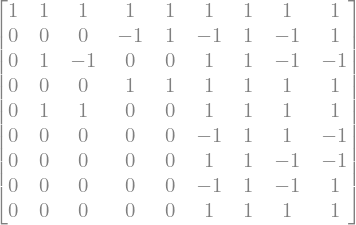

In [3]:
# Transformation matrix C
method.moment_matrix

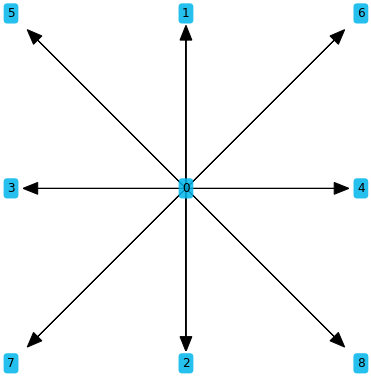

In [4]:
ps.stencil.plot(method.stencil)
method.stencil

### Orthogonal MRTs

For a real MRT method, the moments should be orthogonalized.
One can either orthogonalize using the standard scalar product or a scalar product that is weighted with the lattice weights. If unsure, use the weighted version.

The next cell shows how to get both orthogonalized MRT versions in lbmpy.


In [5]:
weighted_ortho_mrt = create_lb_method(stencil="D2Q9", method="mrt", weighted=True)
weighted_ortho_mrt

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$\omega_{0}$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$3 x^{2} + 3 y^{2} - 2$,$3 u_{0}^{2} + 3 u_{1}^{2}$,$\omega_{1}$
$3 x^{2} y - y$,$0$,$\omega_{2}$
$3 x y^{2} - x$,$0$,$\omega_{2}$
$9 x^{2} y^{2} - 3 x^{2} - 3 y^{2} + 1$,$0$,$\omega_{3}$


In [6]:
ortho_mrt = create_lb_method(stencil="D2Q9", method="mrt", weighted=False)
ortho_mrt

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$\omega_{0}$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$3 x^{2} + 3 y^{2} - 4$,$- 2 \rho + 3 u_{0}^{2} + 3 u_{1}^{2}$,$\omega_{1}$
$3 x^{2} y - 2 y$,$- u_{1}$,$\omega_{2}$
$3 x y^{2} - 2 x$,$- u_{0}$,$\omega_{2}$
$9 x^{2} y^{2} - 6 x^{2} - 6 y^{2} + 4$,$\rho - 3 u_{0}^{2} - 3 u_{1}^{2}$,$\omega_{3}$


One can check if a method is orthogonalized:

In [7]:
ortho_mrt.is_orthogonal, weighted_ortho_mrt.is_weighted_orthogonal

(True, True)

### Define custom MRT method

To choose custom values for the left moment column one can pass a nested list of moments.
Moments that should be relaxed with the same paramter are grouped together.

*lbmpy* also comes with a few templates for this list taken from literature:

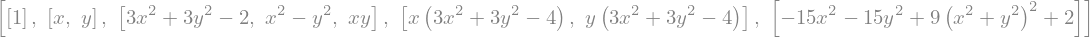

In [8]:
from lbmpy.methods import mrt_orthogonal_modes_literature
from lbmpy.stencils import get_stencil
from lbmpy.moments import MOMENT_SYMBOLS

x, y, z = MOMENT_SYMBOLS

moments = mrt_orthogonal_modes_literature(get_stencil("D2Q9"), is_weighted=True)
moments

This nested moment list can be passed to `create_lb_method`:

In [9]:
create_lb_method(stencil="D2Q9", method="mrt", nested_moments=moments)

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$3 x^{2} + 3 y^{2} - 2$,$3 u_{0}^{2} + 3 u_{1}^{2}$,$\omega_{0}$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$\omega_{0}$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$x \left(3 x^{2} + 3 y^{2} - 4\right)$,$0$,$\omega_{1}$
$y \left(3 x^{2} + 3 y^{2} - 4\right)$,$0$,$\omega_{1}$
$- 15 x^{2} - 15 y^{2} + 9 \left(x^{2} + y^{2}\right)^{2} + 2$,$9 u_{0}^{2} + 9 u_{1}^{2}$,$\omega_{2}$


If one needs to also specify custom equilibrium moments the following approach can be used

In [10]:
rho = sp.symbols("rho")
u = sp.symbols("u_:3")
omega = sp.symbols("omega_:4")

method_table = [
  # Conserved moments     
  (1,    rho,  0 ),
  (x,    u[0], 0 ),
  (y,    u[1], 0 ),
  
  # Shear moments    
  (x*y,       u[0]*u[1],                   omega[0]),
  (x**2-y**2, u[0]**2 - u[1]**2,           omega[0]),
  (x**2+y**2, 2*rho/3 + u[0]**2 + u[1]**2, omega[1]),
  
  # Higher order
  (x * y**2,    u[0]/3,                        omega[2]),
  (x**2 * y,    u[1]/3,                        omega[2]),
  (x**2 * y**2, rho/9 + u[0]**2/3 + u[1]**2/3, omega[3]),  
]
method = create_generic_mrt(get_stencil("D2Q9"), method_table)
method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$\omega_{0}$
$x^{2} + y^{2}$,$\frac{2 \rho}{3} + u_{0}^{2} + u_{1}^{2}$,$\omega_{1}$
$x y^{2}$,$\frac{u_{0}}{3}$,$\omega_{2}$
$x^{2} y$,$\frac{u_{1}}{3}$,$\omega_{2}$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$\omega_{3}$


Instead of manually defining all entries in the method table, *lbmpy* has functions to fill the table according to a specific pattern. For example:
- for a full stencil (D2Q9, D3Q27) there exist exactly 9 or 27 linearly independent moments. These can either be taken as they are, or orthogonalized using Gram-Schmidt, weighted Gram-Schmidt or a Hermite approach
- equilibrium values can be computed from the standard discrete equilibrium of order 1,2 or 3. Alternatively they can also be computed as continuous moments of a Maxwellian distribution

One option is to start with one of *lbmpy*'s built-in methods and modify it with `create_lb_method_from_existing`.
In the next cell we fix the fourth order relaxation rate to a constant, by writing a function that defines how to alter each row of the collision table. This is for demonstration only, of course we could have done it right away when passing in the collision table.

In [11]:
def modification_func(moment, eq, rate):
    if rate == omega[3]:
        return moment, eq, 1.0
    return moment, eq, rate


method = create_lb_method_from_existing(method, modification_func)
method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$x^{2} - y^{2}$,$u_{0}^{2} - u_{1}^{2}$,$\omega_{0}$
$x^{2} + y^{2}$,$\frac{2 \rho}{3} + u_{0}^{2} + u_{1}^{2}$,$\omega_{1}$
$x y^{2}$,$\frac{u_{0}}{3}$,$\omega_{2}$
$x^{2} y$,$\frac{u_{1}}{3}$,$\omega_{2}$
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$1.0$


Our customized method can be directly passed into one of the scenarios. We can for example set up a channel flow with it. Since we used symbols as relaxation rates, we have to pass them in as `kernel_params`.

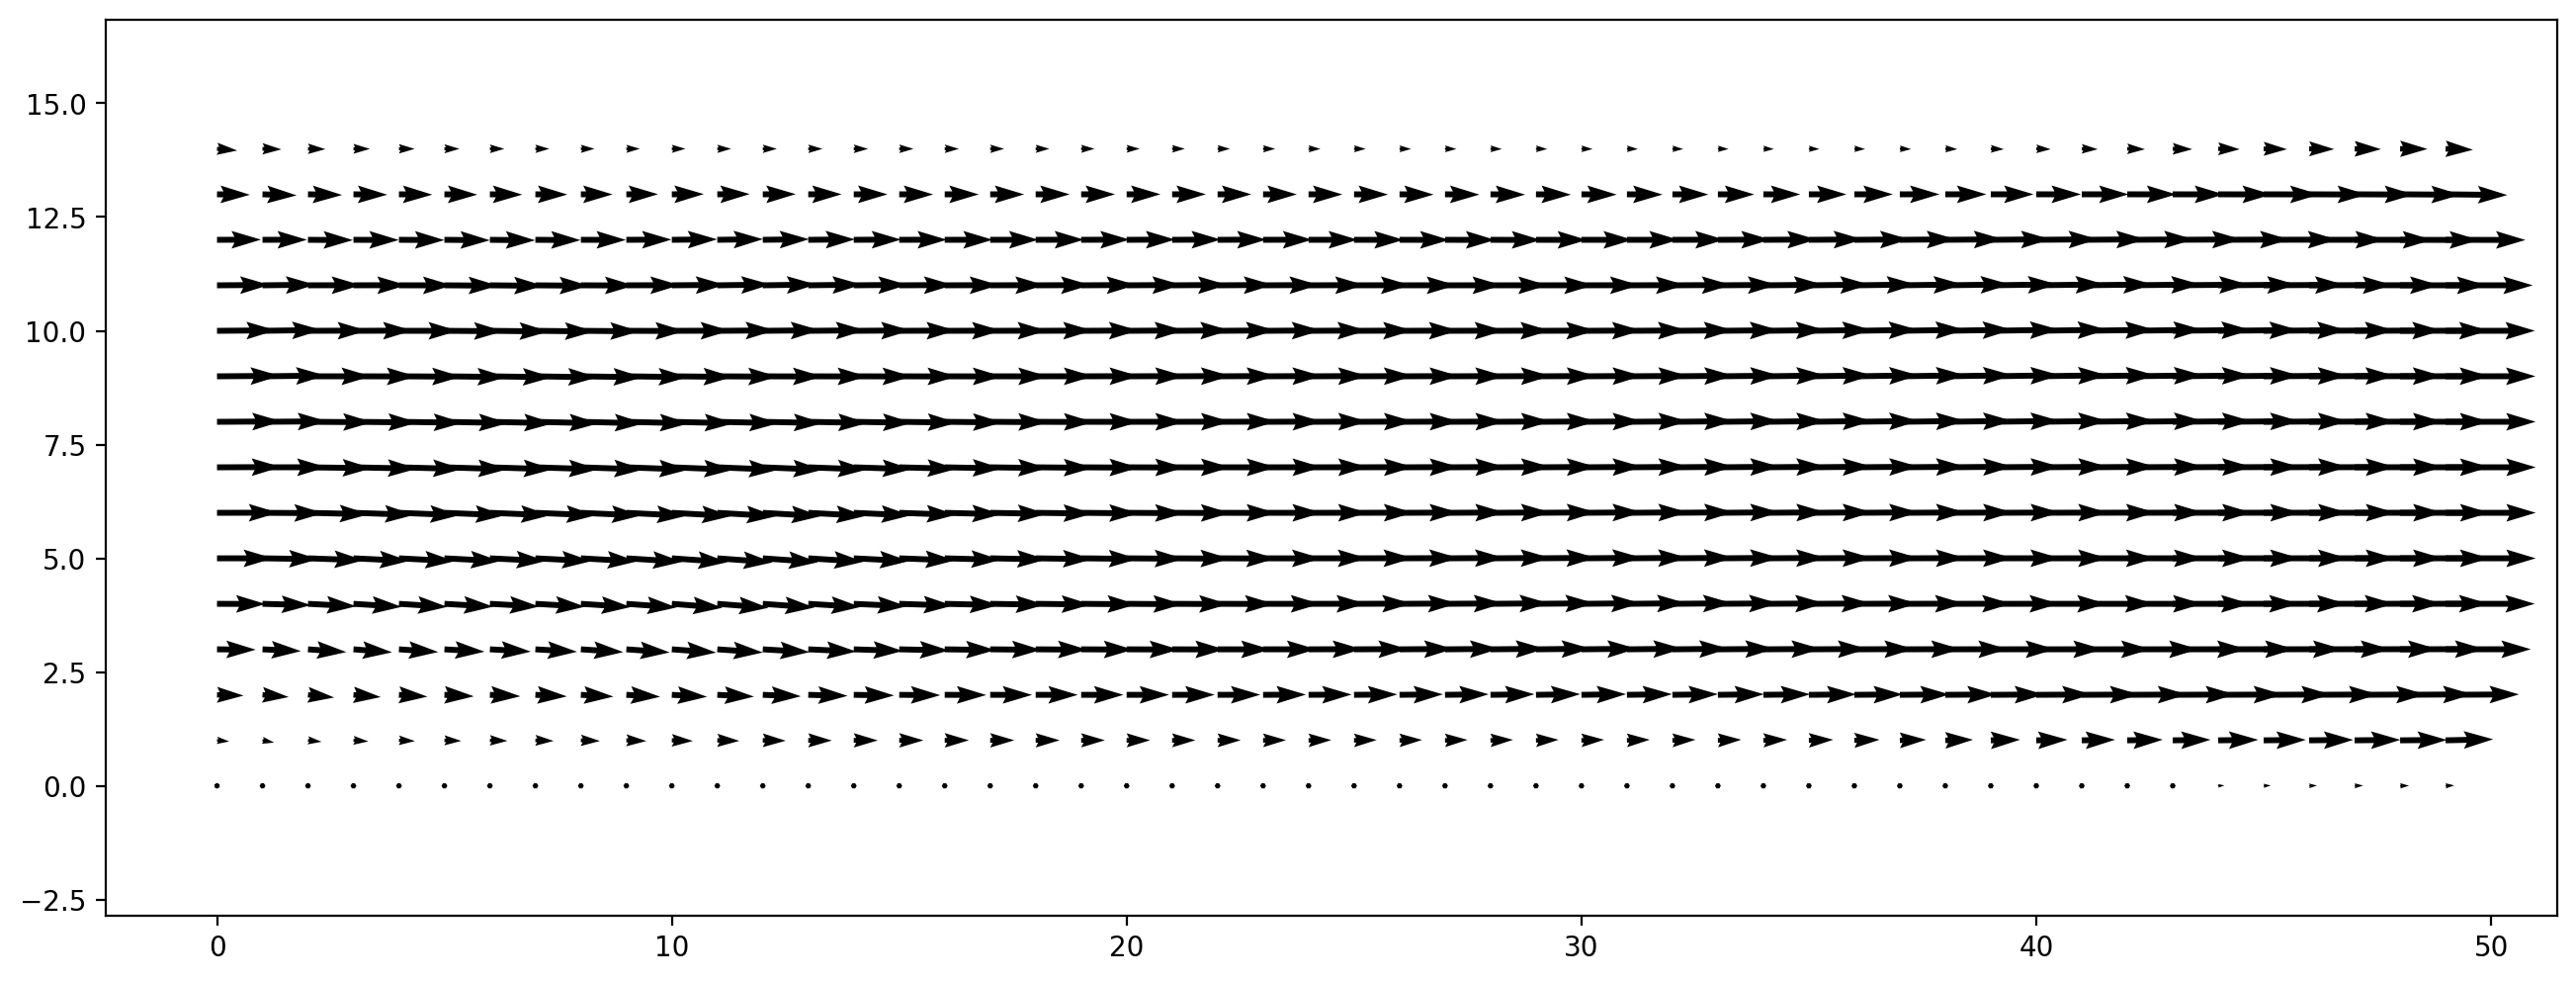

In [12]:
ch = create_channel(domain_size=(100, 30), lb_method=method, u_max=0.05,
                    kernel_params={'omega_0': 1.8, 'omega_1': 1.4, 'omega_2': 1.5})
ch.run(500)
plt.figure(dpi=200)
plt.vector_field(ch.velocity[:, :]);

#### Bonus: Automatic analysis
Above we have created a non-orthogonal MRT, where the shear viscosity and bulk viscosity can be independently controlled. For moment-based methods, *lbmpy* also offers an automatic Chapman Enskog analysis that can find the relation between viscosity and relaxation rate(s):

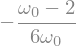

In [13]:
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis
analysis = ChapmanEnskogAnalysis(method)
analysis.get_dynamic_viscosity()

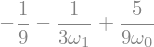

In [14]:
analysis.get_bulk_viscosity()